In [106]:
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree, model_selection, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [107]:
path = './Output/Combined_dataset.csv'
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

df['duration'] = pd.to_numeric(pd.to_timedelta(df['duration']).dt.days, downcast='integer')
df['num_faq'] = df['num_faq'].astype(int)
df['n_comments'] = df['n_comments'].str.replace(',', '').astype(float)

#clean up comments
df['comments'] = df['comments'].apply(lambda x: x.replace('Only backers can post comments. Log in\n',""))
df.sample(3)

(1000, 32)


,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,...,static_usd_rate,urls,usd_pledged,usd_type,story,faq,num_faq,comments,n_comments,duration
461,19,Drawings and paintings of all kinds of Singapo...,"{""id"":22,""name"":""Illustration"",""slug"":""art/ill...",198,SG,2020-10-16 8:03,USD,2020-12-04 1:29,0.754118,20,...,0.740923,"{""web"":{""project"":""https://www.kickstarter.com...",196.344728,domestic,"This year has been a tough year, both in the w...",[' '],0,EllaCreator\n23 days ago\n@Isabel Pita: So gla...,6.0,20
15,2,"One Enterprise Grade Strapi Blog Theme, Food A...","{""id"":51,""name"":""Software"",""slug"":""technology/...",21,US,2019-08-04 14:37,USD,2019-08-22 5:39,1.000000,20000,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",21.000000,domestic,"What this Kickstarter Offers!\nOne Blog theme,...","["" Who, or What is Razroo? Razroo is a softwar...",1,No comments yet.,0.0,15
753,74,An Unofficial Chronological Visual Retrospecti...,"{""id"":45,""name"":""Art Books"",""slug"":""publishing...",7543,US,2020-06-09 17:18,USD,2020-07-11 18:00,1.000000,2300,...,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",7543.920000,domestic,Stretch Goal Progress\nThanks for checking out...,[' '],0,Darren HupkeCreatorSuperbacker\nabout 2 months...,33.0,31


In [108]:
# only keep english projects
from langdetect import detect
df['language'] = [detect(text) for text in df.blurb]
df = df.loc[df['language'] == "en"]

In [109]:
# check shape of df after removing non-english projects
df.shape

(934, 33)

In [110]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'current_currency', 'deadline', 'fx_rate',
       'goal', 'id', 'launched_at', 'location', 'name', 'pledged', 'profile',
       'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type', 'story', 'faq', 'num_faq', 'comments', 'n_comments',
       'duration', 'language'],
      dtype='object')

# Feature Engineering

In [111]:
# Get month/year of launch/deadline
df['month_launched'] = pd.DatetimeIndex(df['launched_at']).month
df['year_launched'] = pd.DatetimeIndex(df['launched_at']).year
df['month_deadline'] = pd.DatetimeIndex(df['deadline']).month
df['year_deadline'] = pd.DatetimeIndex(df['deadline']).year
 
# Convert rows from str to dict
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", "'").replace('u"', '"')
    return json.loads(dict_string)

df.category = df.category.apply(string_to_dict)

# Get category values from dictionary
df['parent_category'] = [d.get('parent_name') for d in df.category]
df['category_name'] = [d.get('name') for d in df.category]
df["parent_category"].fillna("No Parent Category", inplace = True)

# Fill na for text cols
df["story"].fillna(" ", inplace = True)

df.state = df.state.astype('category').cat.codes

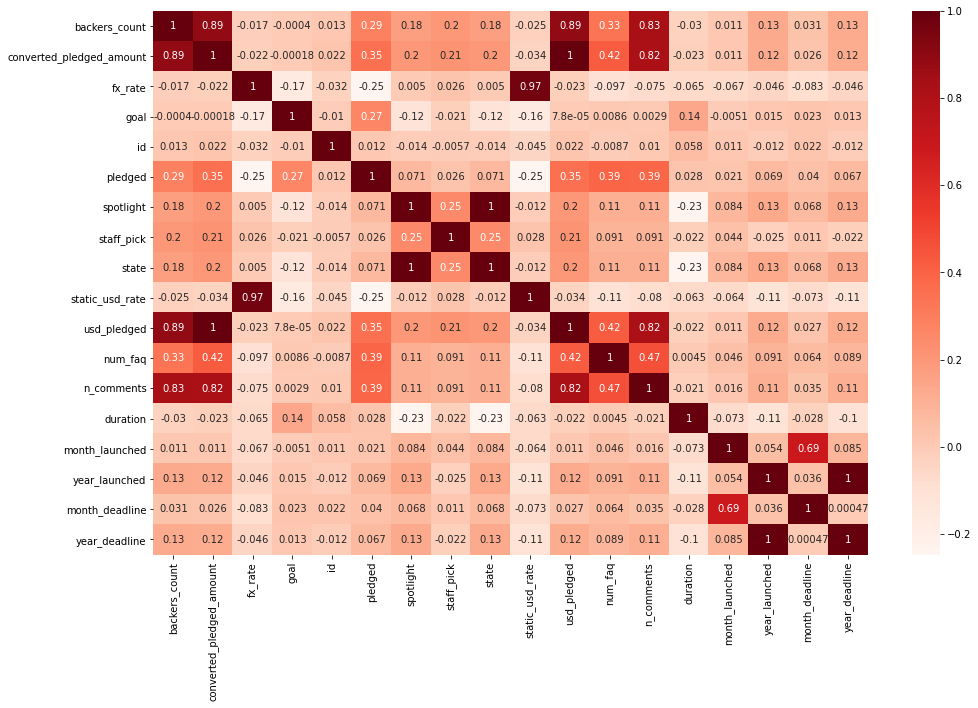

In [112]:
plt.figure(figsize=(16,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [113]:
cols_to_drop = ['profile', 'category', 'created_at', 'location', 'current_currency', 'deadline', 'id', 'launched_at', 'slug', 'source_url', 'state_changed_at', 'urls', 'static_usd_rate', 'usd_pledged', 'converted_pledged_amount', 'spotlight', 'month_deadline', 'year_deadline', 'language']
df = df.drop(cols_to_drop, axis=1)

In [114]:
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name']
num_cols = ['backers_count', 'fx_rate', 'goal', 'pledged', 'num_faq', 'n_comments', 'duration', 'month_launched', 'year_launched']
text_cols = ['blurb', 'name', 'story', 'faq', 'comments']

In [115]:
# Text Analysis using TextBlob
from textblob import TextBlob

# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    # use this line for Python 2 (avoids UnicodeDecodeError for some reviews)
    # blob = TextBlob(text.decode(encoding='utf-8'))
    
    # use this line instead for Python 3
    blob = TextBlob(text)
    
    # return the polarity
    return blob.sentiment.polarity

# create a new DataFrame column for sentiment 
for col in text_cols:
    col_name = col + '_sentiment'
    df[col_name] = df[col].apply(detect_sentiment)
    
df = df.drop(text_cols, axis=1)
df.head(3)

,backers_count,country,fx_rate,goal,pledged,staff_pick,state,usd_type,num_faq,n_comments,duration,month_launched,year_launched,parent_category,category_name,blurb_sentiment,name_sentiment,story_sentiment,faq_sentiment,comments_sentiment
0,1,ES,1.212886,15000,1.0,False,0,domestic,0,0.0,30,6,2016,Technology,3D Printing,0.0,0.0,0.160156,0.0,0.0
1,2,NZ,0.723585,5000,15.0,False,0,domestic,0,0.0,30,8,2015,Food,Farms,0.2,0.4,0.357143,0.0,0.0
2,0,US,1.000000,10000,0.0,False,0,domestic,0,0.0,29,4,2015,Art,Mixed Media,0.5,0.5,0.143182,0.0,0.0


In [355]:
# # Text Analysis using Afinn
# from afinn import Afinn
# afinn = Afinn(emoticons=True)

# # define a function that accepts text and returns the polarity
# def detect_sentiment(text):
#     #afinn = Afinn(emoticons=True)
#     return afinn.score(text)

# # create a new DataFrame column for sentiment 
# for col in text_cols:
#     col_name = col + '_sentiment'
#     df[col_name] = df[col].apply(detect_sentiment)
    
# df = df.drop(text_cols, axis=1)
# df.head(3)

# Feature Transformation

In [116]:
# Split dataset
X = df.drop('state', axis=1)
y = df.state
#y.mean() #0.6370449678800857

# stratify y
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=2019, stratify=y)

In [117]:
# One Hot Encoding
from pandas.api.types import CategoricalDtype 

OHE_df = pd.DataFrame()

for i in categorical_cols:
    OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
    
    OHE_df = pd.concat([X, pd.get_dummies(X[i], prefix=i)],axis=1)

In [118]:
OHE_df = OHE_df.drop(categorical_cols, axis= 1)

OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

In [119]:
print(OHE_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934 entries, 0 to 999
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   backers_count                    934 non-null    int64  
 1   fx_rate                          934 non-null    float64
 2   goal                             934 non-null    int64  
 3   pledged                          934 non-null    float64
 4   num_faq                          934 non-null    int64  
 5   n_comments                       934 non-null    float64
 6   duration                         934 non-null    int8   
 7   month_launched                   934 non-null    int64  
 8   year_launched                    934 non-null    int64  
 9   blurb_sentiment                  934 non-null    float64
 10  name_sentiment                   934 non-null    float64
 11  story_sentiment                  934 non-null    float64
 12  faq_sentiment         

In [189]:
# # apply OneHotEncoder on categorical feature columns
# ohe = OneHotEncoder(handle_unknown = 'ignore') 

# X_train_ohe = ohe.fit_transform(X_train[categorical_cols]) 
# X_test_ohe = ohe.transform(X_test[categorical_cols])

# OHE_train = np.hstack((X_train.drop(categorical_cols, axis=1).values, X_train_ohe.toarray()))
# OHE_test = np.hstack((X_test.drop(categorical_cols, axis=1).values, X_test_ohe.toarray()))

# Text Analysis

In [125]:
# # Term Frequency (count the number of occurrences of each term in each document)
# # TfidfVectorizer (CountVectorizer + TfidfTransformer)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vect = TfidfVectorizer()
# pd.DataFrame(vect.fit_transform(X.comments).toarray(), columns=vect.get_feature_names())

In [126]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn import metrics

# # define a function that accepts a vectorizer and calculates the accuracy
# def tokenize_test(vect, col):
    
#     # create document-term matrices using the vectorizer
#     X_train_dtm = vect.fit_transform(X_train[col])
#     X_test_dtm = vect.transform(X_test[col])
    
#     # print the number of features that were generated
#     print('Features: ', X_train_dtm.shape[1])
    
#     # use Multinomial Naive Bayes to predict the star rating
#     nb = MultinomialNB()
#     nb.fit(X_train_dtm, y_train)
#     y_pred_class = nb.predict(X_test_dtm)
    
#     # print the accuracy of its predictions
#     print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [127]:
# # use TfidfVectorizer with default parameters
# vect = TfidfVectorizer()
# tokenize_test(vect, 'comments')

In [128]:
# # Term Frequency (count the number of occurrences of each term in each document)
# from sklearn.feature_extraction.text import CountVectorizer
# vect = CountVectorizer()
# tokenize_test(vect, 'comments')

# GridSearch

In [120]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [134]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3],
    'min_samples_split': [2, 8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(OHE_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.5min finished


{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 2,
 'n_estimators': 500}

# Random Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier
from numpy import *
random.seed(4222)
classifier = RandomForestClassifier(criterion="entropy", n_estimators=500)
# {'criterion': 'entropy',
#  'max_depth': None, #default
#  'min_samples_split': 2, #default
#  'n_estimators': 500}

In [140]:
print(OHE_train.shape)
print(y_train.shape)
print(OHE_test.shape)
print(y_test.shape)

(747, 80)
(747,)
(187, 80)
(187,)


In [141]:
classifier.fit(OHE_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=500)

# Model Evaluation (AFINN)

In [271]:
# # Evaluate Model 
# y_predict_class = classifier.predict(OHE_test)

# report = """
# The evaluation report is:
# Confusion Matrix:
# {}
# Accuracy: {}
# MSE: {}
# """.format(confusion_matrix(y_test, y_predict_class),
#            accuracy_score(y_test, y_predict_class), 
#            mean_squared_error(y_test, y_predict_class))
# print(report)

# Model Evaluation (TextBlob)

In [142]:
# Evaluate Model 
y_predict_class = classifier.predict(OHE_test)

report = """
The evaluation report is:
Confusion Matrix:
{}
Accuracy: {}
MSE: {}
AUC:{}
""".format(confusion_matrix(y_test, y_predict_class),
           accuracy_score(y_test, y_predict_class), 
           mean_squared_error(y_test, y_predict_class),
           metrics.roc_auc_score(y_test, classifier.predict_proba(OHE_test)[:, 1]))
print(report)


The evaluation report is:
Confusion Matrix:
[[ 64   8]
 [  5 110]]
Accuracy: 0.93048128342246
MSE: 0.06951871657754011
AUC:0.980012077294686

